In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import hickle
from scipy.interpolate import CubicSpline
from scipy.optimize import brentq, curve_fit
from scipy.misc import derivative
from scipy.integrate import quad

In [2]:
# plotting style (optional!)
import matplotlib as mpl
from matplotlib import rc
mpl.style.use('classic')
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = r'\usepackage{mlmodern}'

mpl.rc('xtick', labelsize=27) 
mpl.rc('ytick', labelsize=27)
mpl.rc('xtick', labelsize=27) 
mpl.rc('ytick', labelsize=27)

mpl.rcParams['xtick.major.size'] = 10.0
mpl.rcParams['xtick.major.width'] = 1.75
mpl.rcParams['ytick.major.size'] = 10.0
mpl.rcParams['ytick.major.width'] = 1.75

mpl.rcParams['axes.linewidth'] = 2.0
mpl.rcParams['patch.linewidth'] = 2.0
mpl.rcParams['xtick.major.pad'] = 10.0
mpl.rcParams['ytick.major.pad'] = 10.0

mpl.rcParams['xtick.top'] = False
mpl.rcParams['ytick.right'] = False

mpl.rcParams['xtick.minor.size'] = 5.0
mpl.rcParams['xtick.minor.width'] = 1.75
mpl.rcParams['ytick.minor.size'] = 5.0
mpl.rcParams['ytick.minor.width'] = 1.75

mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.top'] = True

import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

In [3]:
# simple model for Gaia's astrometric uncertainty
def piecewise(x, a):
    return a*np.max([1.0*np.ones(len(x)), 10**(0.2*(x - 14.0))], axis=0)

# function to calculate sigma_fov as a function of distance and absolute G-band mag
def calc_sigma_fov(d, absGmag):
    appGmag = absGmag + 5.0*np.log10(d/10.0)
    
    # list/numpy array
    if type(appGmag) == list or type(appGmag) == np.ndarray:
        sigma_fovs = piecewise(appGmag, 53.89888779)
        return sigma_fovs
    
    # float
    return piecewise(np.array([appGmag]), 53.89888779)[0]

In [4]:
# function to calculate absolute G-band magnitude from stellar mass
def calc_absGmag(mass, coeff=np.array([16.91206805,  24.95258266,   4.0433877 , -13.63108438, 4.77092427])):
    return np.polyval(coeff, np.log10(mass))

In [5]:
# function whose root is the limiting distance
def root_function(d, absGmag, mratio, a, N_sigma):
    return d * calc_sigma_fov(d, absGmag) - 1e6*mratio*a/N_sigma

# function to calculate limiting distance (absGmag, mratio, and a are assumed to be floats)
def calc_limiting_distance(absGmag, mratio, a, N_sigma, d_min=1e-10, d_max=1e10, tol=1e-8):
    if root_function(d_min, absGmag, mratio, a, N_sigma) * root_function(d_max, absGmag, mratio, a, N_sigma) > 0:
        raise ValueError("The root is not bracketed in the given interval. Try adjusting d_min and d_max.")
            
    return brentq(root_function, d_min, d_max, args=(absGmag, mratio, a, N_sigma), xtol=tol)

In [6]:
# load data tabulated from Fig. 16 of Gaia Collaboration et al. (2021)
data = np.genfromtxt('Data/Gaia_VLF_tabulated.csv', delimiter=', ')
Gaia_MGs, Gaia_VLFs = data[:,0], data[:,1]
VLF_cubic_spline = CubicSpline(Gaia_MGs, Gaia_VLFs)

# calculate VLF = dN/dVdMG for some set of absolute mags
def calc_dN_dVdMG(MGs):
    return VLF_cubic_spline(MGs)

# calculate the derivative of absolute magnitude with respect to mass
def calc_dabsGmag_dmass(mass):
    return derivative(calc_absGmag, mass, dx=1e-10)

In [7]:
# calculate the number of searchable stars for stars between Mstar and Mstar+dM, divided by dMstar
def calc_dNsearch_dM(M, m, a, N_sigma, Pmax=9999):
    mratio = m * 0.0009542 / M  # convert to solar masses
    MG = calc_absGmag(M)

    a_Pmax = (Pmax**(2.0/3.0)) * M**(1.0/3.0)  # AU

    if (a > a_Pmax):
        d_limit = 1e-5 # null limiting distance when P > Pmax
    else:
        d_limit = calc_limiting_distance(MG, mratio, a, N_sigma)

    # calculate searchable volume, assuming a z-direction scale height of 300 pc
    H = 300 # pc
    xi = d_limit/H
    volume = (4.0*np.pi/3.0)*(d_limit**3)*3*((0.5*(xi**2) + (1 + xi)*np.exp(-xi) - 1)/(xi**3))

    # calculate dNsearch/dMstar
    dN_dVdMG = calc_dN_dVdMG(MG) # VLF
    dMG_dM = calc_dabsGmag_dmass(M)
    dN_dVdM = dN_dVdMG * np.abs(dMG_dM) # VMF
    dNsearch_dM = dN_dVdM * volume

    return dNsearch_dM

# calculate the number of searchable stars between Mstar1 and Mstar2 by integrating dNsearch_dMstar
def calc_Nsearch(M1, M2, m, a, N_sigma, Pmax=9999):
    integrand = lambda M: calc_dNsearch_dM(M, m, a, N_sigma, Pmax=Pmax)

    # perform the integral numerically
    result, error = quad(integrand, M1, M2)

    return result

In [8]:
# calculate the planet occurrence rate for a given stellar mass, semi-major axis, and planet mass (from Fulton et al. 2021)
def planet_occurrence(M_star, a, C=350.0, beta=-0.86, a0 = 3.6, gamma=1.59):
    C_new = C*(M_star/0.9)
    occurrence_rate = C_new * (a**beta) * (1.0 - np.exp(-(a/a0)**gamma))
    dlogm = np.log(6000) - np.log(30)
    occurrence_rate = occurrence_rate/(719.0*dlogm*0.63)

    return occurrence_rate # returns dNplanets / (dNstars * dlnm * dlna)

# DR5: searchable stars and planet detections

In [9]:
# setup 3D grid of a, mp, and Mstar
n = 50
alog = np.linspace(np.log(0.125), np.log(7.0), n) # log semi-major axis grid
mlog = np.linspace(np.log(0.3), np.log(13.0), n) # log planet mass grid
Mstar = np.linspace(0.1, 2.0, n) # stellar mass grid
dloga = alog[1] - alog[0]
dlogm = mlog[1] - mlog[0]
dMstar = Mstar[1] - Mstar[0]
a, m = np.exp(alog), np.exp(mlog)
amesh, mmesh, Mstarmesh = np.meshgrid(a, m, Mstar) # 3D grid

In [ ]:
# calculate number of searchable stars in dense 3D grid (takes ~1.5 hours on my MacBook)
nsearch = np.zeros(amesh.shape)
for i in tqdm(range(n)):
    for j in range(n):
        for k in range(n):
            nsearch[i, j, k] = calc_Nsearch(Mstar[k], Mstar[k]+dMstar, m[i], a[j], N_sigma=1.0, Pmax=9.5)*dloga*dlogm

# save results
hickle.dump(nsearch, 'Data/Nsearchable_grid_DR5.hkl')

In [10]:
# load results
nsearch = hickle.load('Data/Nsearchable_grid_DR5.hkl')

In [11]:
# count total number of searchable stars
tot_searchable = 0.0
for i in range(n):
    for j in range(n):
        for k in range(n):
            tot_searchable += nsearch[i,j,k]
tot_searchable

6854753.0886079725

In [12]:
# calculate number of detected planets using planet occurrence function
occ = planet_occurrence(Mstarmesh, amesh)
nplanets = occ * nsearch
nplanets.shape

(50, 50, 50)

In [13]:
# count total number of detected planets
tot_detected = 0.0
for i in range(n):
    for j in range(n):
        for k in range(n):
            tot_detected += nplanets[i,j,k]
tot_detected

130272.65773814848

In [14]:
axis = 2
collapsed_amesh, collapsed_mmesh = np.sum(amesh, axis=axis)/n, np.sum(mmesh, axis=axis)/n
collapsed_nsearch = np.sum(nsearch, axis=axis)
collapsed_nplanets = np.sum(nplanets, axis=axis)

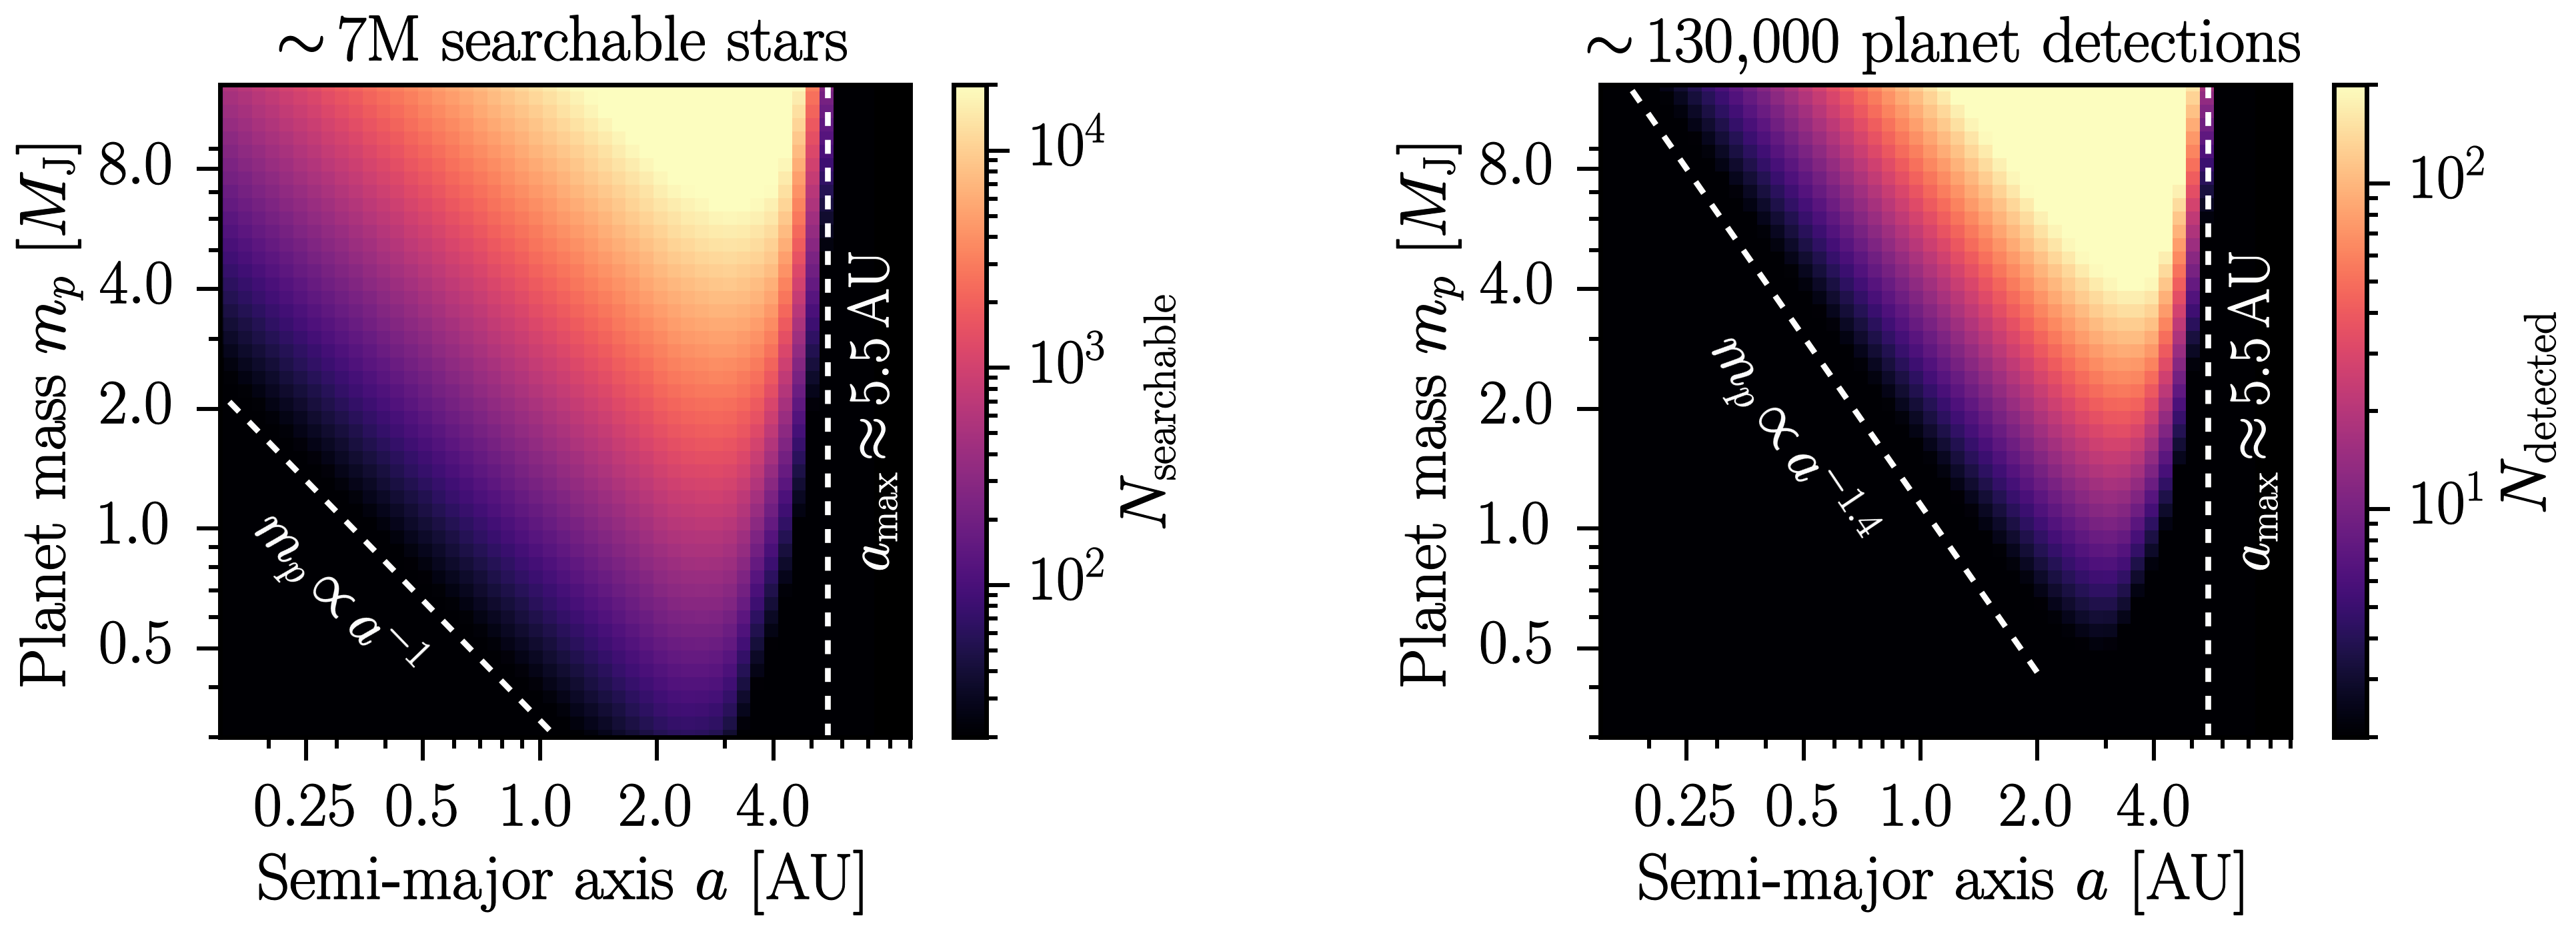

In [15]:
# make plot
fig, axes = plt.subplots(1, 2, figsize=(13*1.2, 5*1.15), facecolor='white', dpi=250)
xticks = [0.25, 0.5, 1.0, 2.0, 4.0]
yticks = [0.5, 1.0, 2.0, 4.0, 8.0]

# grid of searchable stars
mesh1 = axes[0].pcolormesh(
    collapsed_amesh, collapsed_mmesh, collapsed_nsearch,
    cmap='magma',
    norm=mpl.colors.LogNorm(vmin=20, vmax=2e4))
axes[0].set_facecolor('black')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel(r'$\mathrm{Semi}$-$\mathrm{major~axis}~a~\mathrm{[AU]}$', fontsize=28)
axes[0].set_ylabel(r'$\mathrm{Planet~mass}~m_p~[M_{{\rm J}}]$', fontsize=28, labelpad=7)
axes[0].set_ylim(0.3, 13)
axes[0].set_xlim(0.15, 9.0)
axes[0].set_title(r'${\sim}\,7\mathrm{M~searchable~stars}$', fontsize=28, pad=10)
axes[0].set_xticks(xticks)
axes[0].set_xticklabels([rf'${t}$' for t in xticks])
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([rf'${t}$' for t in yticks])
axes[0].tick_params(which="both", direction='out', top=False, right=False)
cbar = plt.colorbar(mesh1, ax=axes[0])
cbar.set_label(r'$N_\mathrm{searchable}$', fontsize=28)
cbar.ax.tick_params(axis='y', which="both", direction='out')

# grid of detected planets
mesh2 = axes[1].pcolormesh(   
    collapsed_amesh, collapsed_mmesh, collapsed_nplanets,
    cmap='magma',
    norm=mpl.colors.LogNorm(vmin=2, vmax=2e2))
axes[1].set_facecolor('black')
axes[1].set_xscale('log')  
axes[1].set_yscale('log')
axes[1].set_ylabel(r'$\mathrm{Planet~mass}~m_p~[M_{{\rm J}}]$', fontsize=28, labelpad=7)
axes[1].set_xlabel(r'$\mathrm{Semi}$-$\mathrm{major~axis}~a~\mathrm{[AU]}$', fontsize=28)
axes[1].set_ylim(0.3, 13)
axes[1].set_xlim(0.15, 9.0)
axes[1].set_title(r'${\sim}\,130{,}000~\mathrm{planet~detections}$', fontsize=28, pad=10)
axes[1].set_xticks(xticks)
axes[1].set_xticklabels([rf'${t}$' for t in xticks])
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([rf'${t}$' for t in yticks])
axes[1].tick_params(which="both", direction='out', top=False, right=False)
cbar = plt.colorbar(mesh2, ax=axes[1])
cbar.set_label(r'$N_\mathrm{detected}$', fontsize=28)
cbar.ax.tick_params(axis='y', which="both", direction='out')

# searchable stars: left ridge
temp_a_grid = np.logspace(np.log10(0.1), np.log10(2.0), 1000)
temp_pred_mp = 0.33*temp_a_grid**(-1.0)
axes[0].plot(temp_a_grid, temp_pred_mp, c='white', lw=2.5, ls='--')
axes[0].text(0.3, 0.67, r'$m_p\,{\propto}\,a^{-1}$', rotation=-46, c='white', horizontalalignment='center', verticalalignment='center', fontsize=25)

# searchable stars: right ridge
axes[0].text(7.3, 2.0, r'$a_\mathrm{max}\,{\approx}\,5.5\,\mathrm{AU}$', rotation=90, c='white', horizontalalignment='center', verticalalignment='center', fontsize=25)
axes[0].axvline(x=5.5, c='white', lw=2.5, ls='--')

# detected planets: left ridge
temp_a_grid = np.logspace(np.log10(0.1), np.log10(2.0), 1000)
temp_pred_mp = 1.15*(temp_a_grid**(-1.4))
axes[1].plot(temp_a_grid, temp_pred_mp, c='white', lw=2.5, ls='--')
axes[1].text(0.46, 1.65, r'$m_p\,{\propto}\,a^{-1.4}$', rotation=-56.2, c='white', horizontalalignment='center', verticalalignment='center', fontsize=25)

# detected planets: right ridge
axes[1].text(7.3, 2.0, r'$a_\mathrm{max}\,{\approx}\,5.5\,\mathrm{AU}$', rotation=90, c='white', horizontalalignment='center', verticalalignment='center', fontsize=25)
axes[1].axvline(x=5.5, c='white', lw=2.5, ls='--')

plt.tight_layout()
plt.subplots_adjust(wspace=0.6)
plt.show()

# DR4: searchable stars and planet detections

In [16]:
# setup 3D grid of a, mp, and Mstar
n = 50
alog = np.linspace(np.log(0.125), np.log(7.0), n) # log semi-major axis grid
mlog = np.linspace(np.log(0.3), np.log(13.0), n) # log planet mass grid
Mstar = np.linspace(0.1, 2.0, n) # stellar mass grid
dloga = alog[1] - alog[0]
dlogm = mlog[1] - mlog[0]
dMstar = Mstar[1] - Mstar[0]
a, m = np.exp(alog), np.exp(mlog)
amesh, mmesh, Mstarmesh = np.meshgrid(a, m, Mstar) # 3D grid

In [ ]:
# calculate number of searchable stars in dense 3D grid (takes ~1.0 hours on my MacBook)
nsearch = np.zeros(amesh.shape)
for i in tqdm(range(n)):
    for j in range(n):
        for k in range(n):
            nsearch[i, j, k] = calc_Nsearch(Mstar[k], Mstar[k]+dMstar, m[i], a[j], N_sigma=1.5, Pmax=4.0)*dloga*dlogm

# save results
hickle.dump(nsearch, 'Data/Nsearchable_grid_DR4.hkl')

In [17]:
# load results
nsearch = hickle.load('Data/Nsearchable_grid_DR4.hkl')

In [18]:
# count total number of searchable stars
tot_searchable = 0.0
for i in range(n):
    for j in range(n):
        for k in range(n):
            tot_searchable += nsearch[i,j,k]
tot_searchable

1178479.0431254092

In [19]:
# calculate number of detected planets using planet occurrence function
occ = planet_occurrence(Mstarmesh, amesh)
nplanets = occ * nsearch
nplanets.shape

(50, 50, 50)

In [20]:
# count total number of detected planets
tot_detected = 0.0
for i in range(n):
    for j in range(n):
        for k in range(n):
            tot_detected += nplanets[i,j,k]
tot_detected

14487.000734307258

In [21]:
axis = 2
collapsed_amesh, collapsed_mmesh = np.sum(amesh, axis=axis)/n, np.sum(mmesh, axis=axis)/n
collapsed_nsearch = np.sum(nsearch, axis=axis)
collapsed_nplanets = np.sum(nplanets, axis=axis)

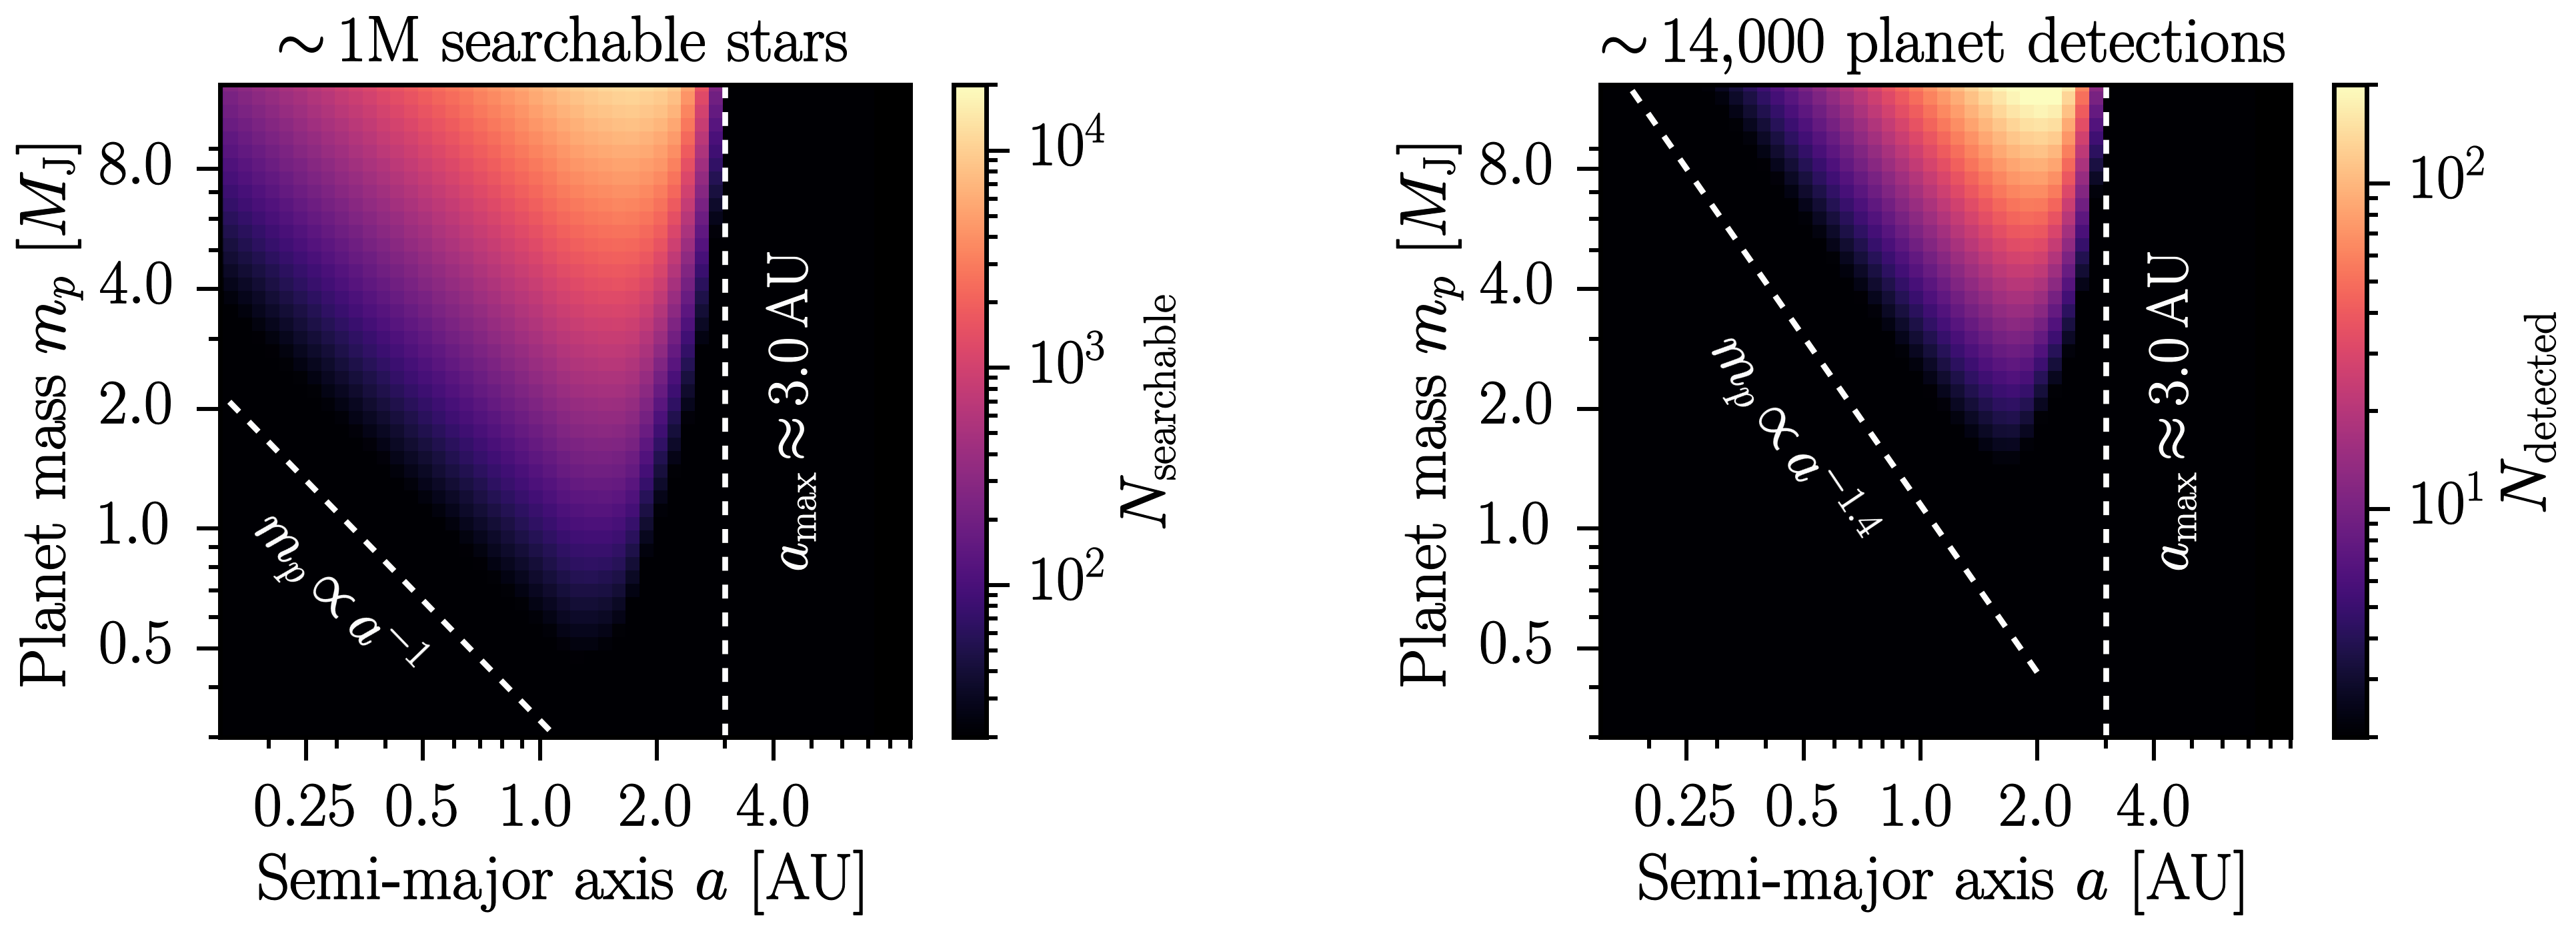

In [22]:
# make plot
fig, axes = plt.subplots(1, 2, figsize=(13*1.2, 5*1.15), facecolor='white', dpi=250)
xticks = [0.25, 0.5, 1.0, 2.0, 4.0]
yticks = [0.5, 1.0, 2.0, 4.0, 8.0]

# grid of searchable stars
mesh1 = axes[0].pcolormesh(
    collapsed_amesh, collapsed_mmesh, collapsed_nsearch,
    cmap='magma',
    norm=mpl.colors.LogNorm(vmin=20, vmax=2e4))
axes[0].set_facecolor('black')
axes[0].set_xscale('log')
axes[0].set_yscale('log')
axes[0].set_xlabel(r'$\mathrm{Semi}$-$\mathrm{major~axis}~a~\mathrm{[AU]}$', fontsize=28)
axes[0].set_ylabel(r'$\mathrm{Planet~mass}~m_p~[M_{{\rm J}}]$', fontsize=28, labelpad=7)
axes[0].set_ylim(0.3, 13)
axes[0].set_xlim(0.15, 9.0)
axes[0].set_title(r'${\sim}\,1\mathrm{M~searchable~stars}$', fontsize=28, pad=10)
axes[0].set_xticks(xticks)
axes[0].set_xticklabels([rf'${t}$' for t in xticks])
axes[0].set_yticks(yticks)
axes[0].set_yticklabels([rf'${t}$' for t in yticks])
axes[0].tick_params(which="both", direction='out', top=False, right=False)
cbar = plt.colorbar(mesh1, ax=axes[0])
cbar.set_label(r'$N_\mathrm{searchable}$', fontsize=28)
cbar.ax.tick_params(axis='y', which="both", direction='out')

# grid of detected planets
mesh2 = axes[1].pcolormesh(   
    collapsed_amesh, collapsed_mmesh, collapsed_nplanets,
    cmap='magma',
    norm=mpl.colors.LogNorm(vmin=2, vmax=2e2))
axes[1].set_facecolor('black')
axes[1].set_xscale('log')  
axes[1].set_yscale('log')
axes[1].set_ylabel(r'$\mathrm{Planet~mass}~m_p~[M_{{\rm J}}]$', fontsize=28, labelpad=7)
axes[1].set_xlabel(r'$\mathrm{Semi}$-$\mathrm{major~axis}~a~\mathrm{[AU]}$', fontsize=28)
axes[1].set_ylim(0.3, 13)
axes[1].set_xlim(0.15, 9.0)
axes[1].set_title(r'${\sim}\,14{,}000~\mathrm{planet~detections}$', fontsize=28, pad=10)
axes[1].set_xticks(xticks)
axes[1].set_xticklabels([rf'${t}$' for t in xticks])
axes[1].set_yticks(yticks)
axes[1].set_yticklabels([rf'${t}$' for t in yticks])
axes[1].tick_params(which="both", direction='out', top=False, right=False)
cbar = plt.colorbar(mesh2, ax=axes[1])
cbar.set_label(r'$N_\mathrm{detected}$', fontsize=28)
cbar.ax.tick_params(axis='y', which="both", direction='out')

# searchable stars: left ridge
temp_a_grid = np.logspace(np.log10(0.1), np.log10(2.0), 1000)
temp_pred_mp = 0.33*temp_a_grid**(-1.0)
axes[0].plot(temp_a_grid, temp_pred_mp, c='white', lw=2.5, ls='--')
axes[0].text(0.3, 0.67, r'$m_p\,{\propto}\,a^{-1}$', rotation=-46, c='white', horizontalalignment='center', verticalalignment='center', fontsize=25)

# searchable stars: right ridge
axes[0].text(4.5, 2.0, r'$a_\mathrm{max}\,{\approx}\,3.0\,\mathrm{AU}$', rotation=90, c='white', horizontalalignment='center', verticalalignment='center', fontsize=25)
axes[0].axvline(x=3.0, c='white', lw=2.5, ls='--')

# detected planets: left ridge
temp_a_grid = np.logspace(np.log10(0.1), np.log10(2.0), 1000)
temp_pred_mp = 1.15*(temp_a_grid**(-1.4))
axes[1].plot(temp_a_grid, temp_pred_mp, c='white', lw=2.5, ls='--')
axes[1].text(0.46, 1.65, r'$m_p\,{\propto}\,a^{-1.4}$', rotation=-56.2, c='white', horizontalalignment='center', verticalalignment='center', fontsize=25)

# detected planets: right ridge
axes[1].text(4.5, 2.0, r'$a_\mathrm{max}\,{\approx}\,3.0\,\mathrm{AU}$', rotation=90, c='white', horizontalalignment='center', verticalalignment='center', fontsize=25)
axes[1].axvline(x=3.0, c='white', lw=2.5, ls='--')

plt.tight_layout()
plt.subplots_adjust(wspace=0.6)
plt.show()